# Business Problem

Human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting.

In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions. Their attempt at building a model to identify these bids using behavioral data, including bid frequency over short periods of time, has proven insufficient.

# Goal

Identify online auction bids that are placed by "robots", helping the site owners easily flag these users for removal from their site to prevent unfair auction activity. 

# Setup

In [1]:
import os
import numpy as np
import pandas as pd

# For data visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get Data

In [2]:
bids = pd.read_csv("data/bids.csv")
bidders_train = pd.read_csv("data/train.csv")
bidders_test = pd.read_csv("data/test.csv")

## Understanding the data

**For the bidder dataset**
* bidder_id – Unique identifier of a bidder.
* payment_account – Payment account associated with a bidder. These are obfuscated to protect privacy. 
* address – Mailing address of a bidder. These are obfuscated to protect privacy. 
* outcome – Label of a bidder indicating whether or not it is a robot. Value 1.0 indicates a robot, where value 0.0 indicates human. 
    * The outcome was half hand labeled, half stats-based. There are two types of "bots" with different levels of proof:
        1. Bidders who are identified as bots/fraudulent with clear proof. Their accounts were banned by the auction site.
        2. Bidder who may have just started their business/clicks or their stats exceed from system wide average. There are no clear proof that they are bots. 


**For the bid dataset**
* bid_id - unique id for this bid
* bidder_id – Unique identifier of a bidder (same as the bidder_id used in train.csv and test.csv)
* auction – Unique identifier of an auction
* merchandise –  The category of the auction site campaign, which means the bidder might come to this site by way of searching for "home goods" but ended up bidding for "sporting goods" - and that leads to this field being "home goods". This categorical field could be a search term, or online advertisement. 
* device – Phone model of a visitor
* time - Time that the bid is made (transformed to protect privacy).
* country - The country that the IP belongs to
* ip – IP address of a bidder (obfuscated to protect privacy).
* url - url where the bidder was referred from (obfuscated to protect privacy). 

## Take a Quick Look at the Data Structure

In [3]:
# Get a sense of our data
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


In [4]:
# Check data types
bids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7656334 entries, 0 to 7656333
Data columns (total 9 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   bid_id       int64 
 1   bidder_id    object
 2   auction      object
 3   merchandise  object
 4   device       object
 5   time         int64 
 6   country      object
 7   ip           object
 8   url          object
dtypes: int64(2), object(7)
memory usage: 525.7+ MB


In [5]:
# Check for missing values
bids.isnull().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

In [6]:
# Check number of unique values in non-numerical attributes
bids.describe(include=['O'])

,bidder_id,auction,merchandise,device,country,ip,url
count,7656334,7656334,7656334,7656334,7647475,7656334,7656334
unique,6614,15051,10,7351,199,2303991,1786351
top,f5b2bbad20d1d7ded3ed960393bec0f40u6hn,jqx39,mobile,phone4,in,37.95.134.218,vasstdc27m7nks3
freq,515033,537347,2126587,706573,1788731,61203,3499409


In [7]:
bidders_train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [8]:
bidders_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2013 entries, 0 to 2012
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bidder_id        2013 non-null   object 
 1   payment_account  2013 non-null   object 
 2   address          2013 non-null   object 
 3   outcome          2013 non-null   float64
dtypes: float64(1), object(3)
memory usage: 63.0+ KB


In [11]:
# To check if there's any duplicate bidder_id
bidders_train.describe(include=['O'])

,bidder_id,payment_account,address
count,2013,2013,2013
unique,2013,2013,2013
top,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4
freq,1,1,1


In [7]:
bidders_test.head()

,bidder_id,payment_account,address
0,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c
1,a921612b85a1494456e74c09393ccb65ylp4y,a3d2de7675556553a5f08e4c88d2c228rs17i,a3d2de7675556553a5f08e4c88d2c228klidn
2,6b601e72a4d264dab9ace9d7b229b47479v6i,925381cce086b8cc9594eee1c77edf665zjpl,a3d2de7675556553a5f08e4c88d2c228aght0
3,eaf0ed0afc9689779417274b4791726cn5udi,a3d2de7675556553a5f08e4c88d2c228nclv5,b5714de1fd69d4a0d2e39d59e53fe9e15vwat
4,cdecd8d02ed8c6037e38042c7745f688mx5sf,a3d2de7675556553a5f08e4c88d2c228dtdkd,c3b363a3c3b838d58c85acf0fc9964cb4pnfa


In [13]:
# To check if there's any duplicate bidder_id
bidders_test.describe(include=['O'])

,bidder_id,payment_account,address
count,4700,4700,4700
unique,4700,4700,4700
top,49bb5a3c944b8fc337981cc7a9ccae41u31d7,a3d2de7675556553a5f08e4c88d2c228htx90,5d9fa1b71f992e7c7a106ce4b07a0a754le7c
freq,1,1,1


**bids**
* "country" have 8859 (0.1%) missing values. Considering the small proportion, let's ignore it first.
* "bid_id" current data type is int64, which should had been object instead since it is an unique identifier for each bid.
* "time" has been transformed to preserve privacy. Let's ignore it first in our baseline model.
* Currently our bids dataset and our target label is in separate datasets, we can't do much without the target label. Let's aggregate our bids dataset and merge it with the bidder_train set for further data exploration.

**bidders_train**
* "outcome" is a float64. Let's convert to int64.

# Explore the Data

In [40]:
# Create a list of columns for counting
grouping_cols = list(bids.columns)
grouping_cols.remove('bidder_id')


In [47]:
# Group by "bidder_id"
bids_grouped = bids.groupby("bidder_id")[grouping_cols].nunique().reset_index()

In [48]:
# Preview the grouped dataframe
bids_grouped.head()

,bidder_id,bid_id,auction,merchandise,device,time,country,ip,url
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1
1,002d229ffb247009810828f648afc2ef593rb,2,1,1,2,2,1,1,1
2,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,1,3,2
4,00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,20,1,10,7


In [49]:
# merge the bids_grouped df with bidders_train df
train_df = bidders_train.merge(bids_grouped, how='left', on="bidder_id")

In [50]:
# Preview the merged df
train_df.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0


In [54]:
# To confirm that our dataframes are merged correctly
print("bids_grouped df's rows and columns:", bids_grouped.shape)
print("bidders_train df's rows and columns:",bidders_train.shape)
print("train_df df's rows and columns:",train_df.shape)

bids_grouped df's rows and columns: (6614, 9)
bidders_train df's rows and columns: (2013, 4)
train_df df's rows and columns: (2013, 12)


In [55]:
# Convert the "outcome" to int64
train_df["outcome"] = train_df["outcome"].apply(np.int64)

In [60]:
# Check if the "outcome" is transformed correctly
# At the same time, let's check whether our data is imbalance.
train_df["outcome"].value_counts(normalize=True) * 100

0    94.883259
1     5.116741
Name: outcome, dtype: float64

We have a imbalance dataset. We will need to handle this later.

In [65]:
# Let's check for missing values again
train_df.isnull().sum()

bidder_id           0
payment_account     0
address             0
outcome             0
bid_id             29
auction            29
merchandise        29
device             29
time               29
country            29
ip                 29
url                29
dtype: int64

In [66]:
# Let's look at these records with missing values
train_df[train_df.isnull().any(axis=1)]

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url
49,5f50c6187a179e2ee7ba2fbcfc845c7a1smgr,7326f0a1592b18cb1e6ed7c8ebbd03a72qf7p,a3d2de7675556553a5f08e4c88d2c228uaoqg,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,02bde521e763e4f4e590e8368149e04a96il9,a3d2de7675556553a5f08e4c88d2c2286r1lb,935d2083173e96f099816c1b1f7ee249kk8zo,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175,dd661e2d6e79a5b3e66c82373d50f3ee86k85,e805bf9d2399ddc37a194e04703a333c7bv82,2c2b8b44b1615ef6d632fb115a85794djmktr,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,908ce7060337fd8550760a100921f6f7wsemn,a3d2de7675556553a5f08e4c88d2c2282yldz,39b2bdec29461f8a0ae2a5a5b01d259fik8r7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,b64c209b3d1d91a663d134961af89125u0s9a,f7558102989f5665bbbea00358f8434adf9o9,5c9de1da50cc32a29ffd596ae24cd2be24cly,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,96b1df591dbbf3a002578574671d9ff1rmzev,a3d2de7675556553a5f08e4c88d2c2288tx3v,1a1d480ca96a50e5fa8af28cf9121d80gx8g2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,d2138bce99f535c244dab68652ccfa2enshxk,72a51aa2faf94e7ffdf736fdb389d4efpyojt,458d233d676d8f62406213ab319b8334dbdxh,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,c08e5e3325e2f4fea171f24ca018e675we8kj,efd15ad70741e38f212ac919ca569615r3g33,81d6c498369ab4af3fea529406dc7d96flle8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
339,187636e527504df29bf42d4a2b7767e54bgv7,a3d2de7675556553a5f08e4c88d2c2281swzb,a3d2de7675556553a5f08e4c88d2c2281rrln,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,74f153bd134afc92866a6bc5cceb2088120y0,a3d2de7675556553a5f08e4c88d2c228fd0s8,796f3dd849480319c21677833dc1a6c87c6p1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It appears that these bidder_id did not make any bids before, thus explaining why there are missing values in all the attributes (recall that we did an unique count). Since the "outcome" of these records are all 0. We can safely drop them as they will not provide us much value in predicting our target.

In [70]:
train_df.describe()

,outcome,bid_id,auction,merchandise,device,time,country,ip,url
count,2013.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000
mean,0.051167,1547.995968,62.585685,1.000504,78.602319,1305.318548,13.300403,675.043347,346.057964
std,0.220394,14701.515067,147.306644,0.022451,187.731137,9621.413993,23.437549,4790.427419,2676.988261
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,0.000000,3.000000,2.000000,1.000000,2.000000,3.000000,1.000000,2.000000,1.000000
50%,0.000000,18.000000,10.000000,1.000000,8.000000,18.000000,3.000000,12.000000,5.000000
75%,0.000000,211.750000,46.250000,1.000000,59.000000,211.750000,12.000000,116.250000,40.000000
max,1.000000,515033.000000,1623.000000,2.000000,2618.000000,283463.000000,178.000000,111918.000000,81376.000000


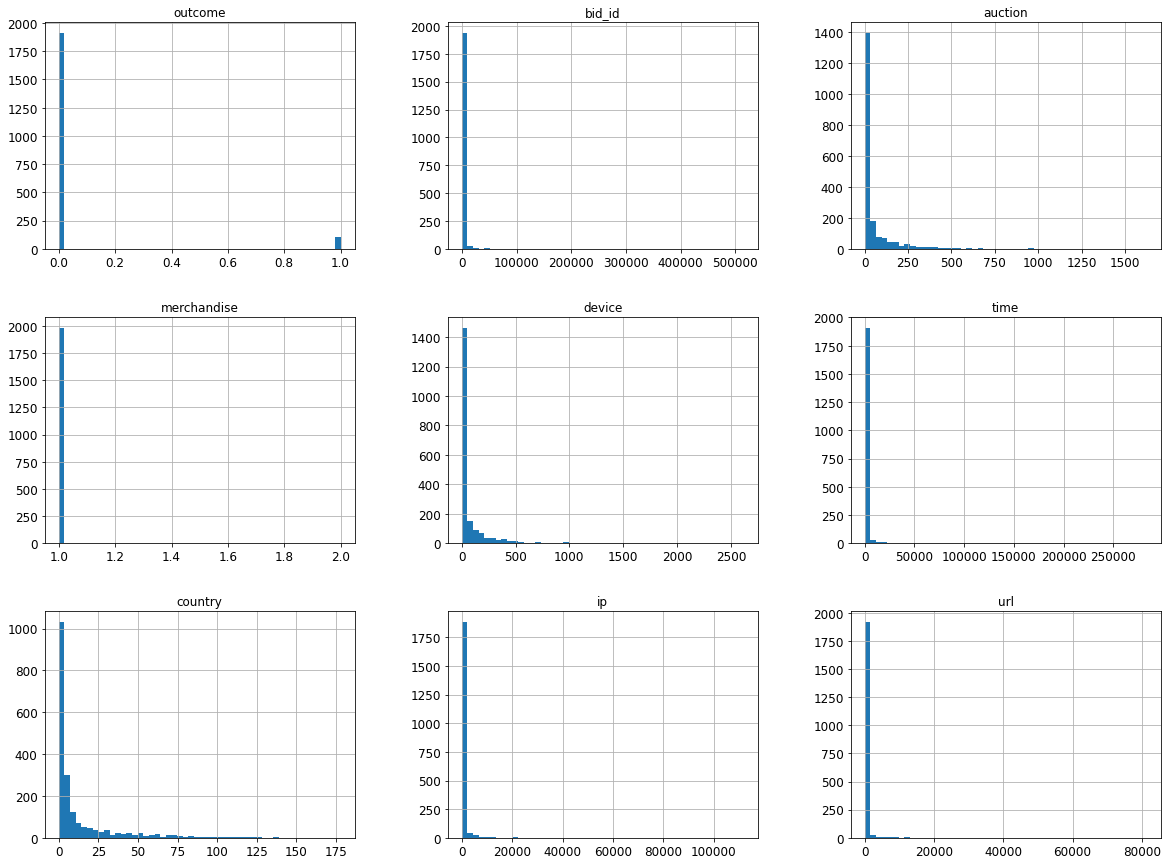

In [73]:
train_df.hist(bins=50, figsize=(20,15));

## Looking for correlation

In [68]:
corr_matrix = train_df.corr()

In [69]:
corr_matrix["outcome"].sort_values(ascending=False)

outcome        1.000000
auction        0.131014
country        0.130027
device         0.105990
ip             0.083686
time           0.057541
bid_id         0.039103
url            0.017358
merchandise   -0.005255
Name: outcome, dtype: float64

# Prepare the Data

# Shortlist Promising Models

# Fine-Tune the System